#**Loading and Exploring the Dataset**



In [1]:
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [52]:
# Load the datasets
location_data = pd.read_csv('/content/drive/MyDrive/locationData.csv')
weather_data = pd.read_csv('/content/drive/MyDrive/weatherData.csv')

# Display the first few rows of each dataset
print(location_data.head())
print(weather_data.head())


   location_id  latitude  longitude  elevation  utc_offset_seconds  \
0            0  6.924429   79.90725          4               19800   
1            1  7.065026   79.96622         19               19800   
2            2  6.572935   80.02519          5               19800   
3            3  7.275923   80.62659        499               19800   
4            4  7.486819   80.52632        362               19800   

       timezone  timezone_abbreviation city_name  
0  Asia/Colombo                    530   Colombo  
1  Asia/Colombo                    530   Gampaha  
2  Asia/Colombo                    530  Kalutara  
3  Asia/Colombo                    530     Kandy  
4  Asia/Colombo                    530    Matale  
   location_id      date  weather_code (wmo code)  temperature_2m_max (°C)  \
0            0  1/1/2010                        1                     30.1   
1            0  1/2/2010                       51                     30.1   
2            0  1/3/2010               

In [53]:
print(location_data.columns)

Index(['location_id', 'latitude', 'longitude', 'elevation',
       'utc_offset_seconds', 'timezone', 'timezone_abbreviation', 'city_name'],
      dtype='object')


In [54]:
print(weather_data.columns)

Index(['location_id', 'date', 'weather_code (wmo code)',
       'temperature_2m_max (°C)', 'temperature_2m_min (°C)',
       'temperature_2m_mean (°C)', 'apparent_temperature_max (°C)',
       'apparent_temperature_min (°C)', 'apparent_temperature_mean (°C)',
       'daylight_duration (s)', 'sunshine_duration (s)',
       'precipitation_sum (mm)', 'rain_sum (mm)', 'precipitation_hours (h)',
       'wind_speed_10m_max (km/h)', 'wind_gusts_10m_max (km/h)',
       'wind_direction_10m_dominant (°)', 'shortwave_radiation_sum (MJ/m²)',
       'et0_fao_evapotranspiration (mm)', 'sunrise', 'sunset'],
      dtype='object')


#**Data Preprocessing**

In [55]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import numpy as np

In [56]:
# Ensure the 'date' column is parsed as a datetime object
weather_data['date'] = pd.to_datetime(weather_data['date'])

# One-hot encoding for city/district (using location_id)
onehotencoder = OneHotEncoder(sparse_output=False)

# Fit and transform the location_id (city) into numerical columns
location_encoded = onehotencoder.fit_transform(weather_data[['location_id']])

# Add the one-hot encoded columns back to the weather_data DataFrame
location_encoded_df = pd.DataFrame(location_encoded, columns=[f"location_{int(i)}" for i in range(location_encoded.shape[1])])
weather_data = pd.concat([weather_data, location_encoded_df], axis=1)

In [57]:
# Feature selection (including city/district features)
features = weather_data[['temperature_2m_mean (°C)',
                         'daylight_duration (s)',
                         'precipitation_sum (mm)',
                         'wind_speed_10m_max (km/h)',
                         'sunshine_duration (s)',
                         'apparent_temperature_mean (°C)'] + location_encoded_df.columns.tolist()]

In [58]:
# Handling missing values (example: forward fill)
features.fillna(method='ffill', inplace=True)

<ipython-input-58-f0f8142d3af1>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features.fillna(method='ffill', inplace=True)
<ipython-input-58-f0f8142d3af1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.fillna(method='ffill', inplace=True)


In [59]:
# Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(features)

In [60]:
# Reshaping for CNN (timesteps, features)
timesteps = 30  # Example: 30 time steps for past data
X, y = [], []

for i in range(timesteps, len(scaled_data)):
    X.append(scaled_data[i-timesteps:i])
    y.append(scaled_data[i, 0])  # Assuming temperature is the target

X, y = np.array(X), np.array(y)

# Reshape X to fit the Conv1D input
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

#**Model Architecture**

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout

In [62]:
# Define the CNN model
model = Sequential()

# Adding convolutional layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Flatten())

# Adding dense layers
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))  # Dropout to avoid overfitting
model.add(Dense(1))  # Output layer for temperature prediction

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#**Training the Model**

In [74]:
from sklearn.model_selection import train_test_split

In [75]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
3559/3559 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - loss: 0.0085 - val_loss: 0.0012
Epoch 2/50
3559/3559 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 3/50
3559/3559 ━━━━━━━━━━━━━━━━━━━━ 34s 10ms/step - loss: 0.0012 - val_loss: 7.9095e-04
Epoch 4/50
3559/3559 ━━━━━━━━━━━━━━━━━━━━ 43s 10ms/step - loss: 0.0011 - val_loss: 6.4648e-04
Epoch 5/50
3559/3559 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - loss: 0.0011 - val_loss: 7.3102e-04
Epoch 6/50
3559/3559 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - loss: 0.0010 - val_loss: 7.7360e-04
Epoch 7/50
3559/3559 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - loss: 9.9742e-04 - val_loss: 8.5295e-04
Epoch 8/50
3559/3559 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - loss: 0.0010 - val_loss: 6.2732e-04
Epoch 9/50
3559/3559 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - loss: 9.9177e-04 - val_loss: 6.2989e-04
Epoch 10/50
3559/3559 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - loss: 9.7250e-04 - val_loss: 6.2083e-04
Epoch 11/50
3559/3559 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - 

#**Model Evaluation**

In [77]:
from sklearn.metrics import mean_squared_error, r2_score

In [79]:
# Predicting on the test data
predictions = model.predict(X_test)

# Calculate MSE
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate R² score
r2 = r2_score(y_test, predictions)
print(f"R² Score: {r2}")

890/890 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Mean Squared Error (MSE): 0.0006234881250884576
Root Mean Squared Error (RMSE): 0.024969744193492602
R² Score: 0.9702946413003914


#**Making Predictions**

In [80]:
# Create a dummy array for inverse transformation
dummy_pred = np.zeros((predictions.shape[0], scaled_data.shape[1]))  # Same number of features as original
dummy_pred[:, 0] = predictions[:, 0]  # Place predictions in the first column (assuming temperature is in the first column)

# Inverse transform only the temperature column
predictions = scaler.inverse_transform(dummy_pred)[:, 0]

# Do the same for y_test to bring it back to the original scale
dummy_test = np.zeros((y_test.shape[0], scaled_data.shape[1]))
dummy_test[:, 0] = y_test
y_test = scaler.inverse_transform(dummy_test)[:, 0]

# Display some predictions vs actual values
for i in range(10):
    print(f"Predicted: {predictions[i]}, Actual: {y_test[i]}")

Predicted: 23.91826319694519, Actual: 24.5
Predicted: 26.33941410779953, Actual: 26.4
Predicted: 27.391402792930602, Actual: 26.6
Predicted: 27.972286581993103, Actual: 27.9
Predicted: 26.25377240180969, Actual: 25.7
Predicted: 23.82761061191559, Actual: 22.599999999999998
Predicted: 16.199278461933137, Actual: 15.8
Predicted: 26.51602027416229, Actual: 26.6
Predicted: 26.952607691287994, Actual: 26.6
Predicted: 29.616515493392946, Actual: 29.5


#**Data Visualization**

In [65]:
import matplotlib.pyplot as plt

In [68]:
# Create a dictionary to map location_id to city_name from location_data
location_mapping = dict(zip(location_data['location_id'], location_data['city_name']))

# Map the city names to the weather_data dataframe
weather_data['city_name'] = weather_data['location_id'].map(location_mapping)

# Check if mapping worked
print(weather_data[['location_id', 'city_name']].head())

   location_id city_name
0            0   Colombo
1            0   Colombo
2            0   Colombo
3            0   Colombo
4            0   Colombo


###**Line Plot for Temperature Over Time**

In [76]:
import seaborn as sns

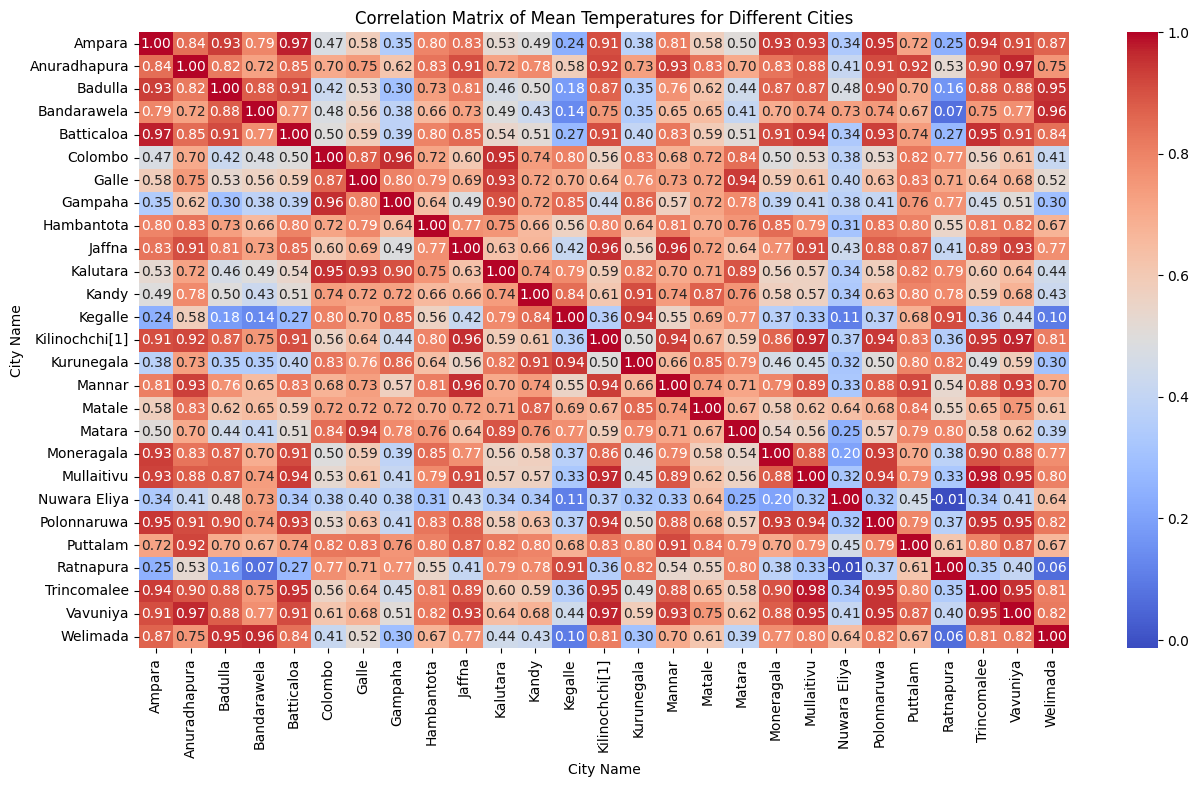

In [82]:
# Convert 'date' column to datetime format
weather_data['date'] = pd.to_datetime(weather_data['date'])

# Pivot the data to create a heatmap-friendly format
heatmap_data = weather_data.pivot_table(index='date', columns='city_name', values='temperature_2m_mean (°C)')

# Calculate the correlation matrix
correlation_matrix = heatmap_data.corr()

# Create the correlation heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Mean Temperatures for Different Cities')
plt.xlabel('City Name')
plt.ylabel('City Name')
plt.show()

###**Bar Plot for Monthly Precipitation**

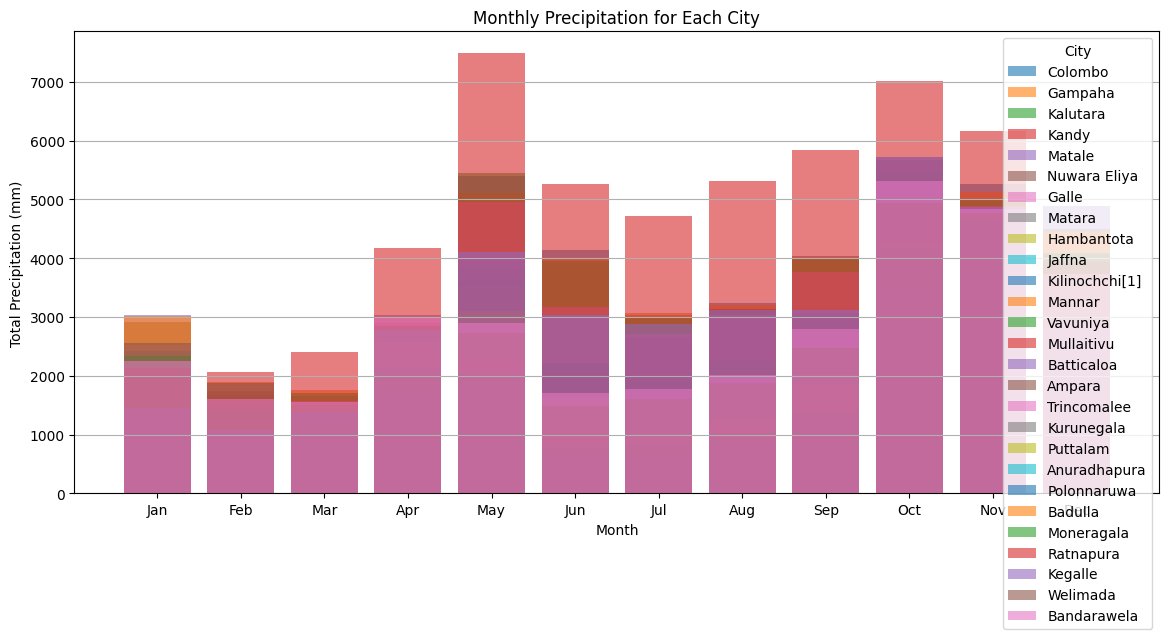

In [72]:
# convert 'date' column to datetime format and extract month
weather_data['date'] = pd.to_datetime(weather_data['date'])
weather_data['month'] = weather_data['date'].dt.month

# Visualizing Monthly Precipitation for Each City
plt.figure(figsize=(14, 6))
for city_name in weather_data['city_name'].unique():
    monthly_precipitation = weather_data[weather_data['city_name'] == city_name].groupby('month')['precipitation_sum (mm)'].sum()
    plt.bar(monthly_precipitation.index, monthly_precipitation, alpha=0.6, label=city_name)

plt.title('Monthly Precipitation for Each City')
plt.xlabel('Month')
plt.ylabel('Total Precipitation (mm)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='City')
plt.grid(axis='y')
plt.show()

###**Scatter Plot for Mean Temperature vs. Precipitation**

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


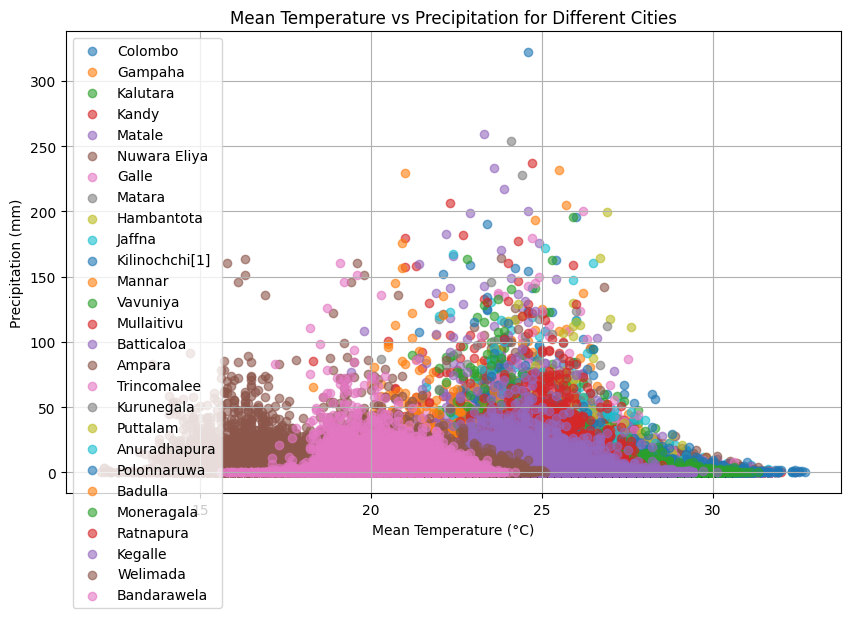

In [73]:
plt.figure(figsize=(10, 6))
for city_name in weather_data['city_name'].unique():
    city_data = weather_data[weather_data['city_name'] == city_name]
    plt.scatter(city_data['temperature_2m_mean (°C)'], city_data['precipitation_sum (mm)'], alpha=0.6, label=city_name)

plt.title('Mean Temperature vs Precipitation for Different Cities')
plt.xlabel('Mean Temperature (°C)')
plt.ylabel('Precipitation (mm)')
plt.legend()
plt.grid(True)
plt.show()
